# SDS 3386 Assignment 5 - Regression

2023 Fall, Rahul Atre

Total Marks: 20

In [1]:
import pandas as pd
import numpy as np
import altair as alt

In [2]:
# Only run these lines if you need to
import warnings
warnings.filterwarnings('ignore')

The first two questions are about regression, using Scikit-learn. See:

- Week 7 Lab
- https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html .


## Question 1: Simple linear regression (7 marks)

The aim of this question is to predict penguin body mass from flipper length.

### A)

Load the penguins dataset and drop all rows with any missing values. Plot flipper length vs. body mass, choosing axis scales so that the data points are easy to see and the chart doesn't have lots of white space.

*Note: it would in general be best practice to first select only the variables we are using and then drop rows with missing data. But doing it this way ensures that we consider the same penguins as in Question 2.*

In [3]:
# Solution to part a
pen = pd.read_csv("penguins.csv")
#pen = pen[['flipper_length_mm', 'body_mass_g']]
pen = pen.dropna()

chart = alt.Chart(pen).encode(
    x = alt.X('flipper_length_mm', scale = alt.Scale(zero = False), title = "Flipper Length"),
    y = alt.Y("body_mass_g", scale = alt.Scale(zero = False), title = "Body Mass")
).mark_circle()

chart + chart.transform_regression('flipper_length_mm','body_mass_g').mark_line(color='red')

alt.LayerChart(...)

### B)

Create two dataframes: `X` containing only the flipper length column, and `y` containing only the body mass column.

Split the data randomly into training and test sets, containing 2/3 and 1/3 of the data respectively, using `sklearn.model_selection.train_test_split`, as follows:

`X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)`
     
Notes: 

- `random_state` is the "seed" of the random number generator. If you choose a different seed (or don't specify it, so that a default is used), you will probably get slightly different results. Using the specified random state makes it easier to compare methods, and makes the assignment easier to mark.

- The output of `train_test_split` is four Pandas dataframes.

In [4]:
# Solution to part b

from sklearn.model_selection import train_test_split

X = pen[['flipper_length_mm']]
y = pen[['body_mass_g']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

### C)

Using `sklearn.linear_model.LinearRegression`, fit a linear model, using only the training data. Print the coefficients of the fitted model, which are: the slope `model.coef_[0]` and the intercept `model.intercept_`. Do a sanity check on this model, by calculating "by hand" the `y` value predicted by this model if `X` equals $200$, using only arithmetic (i.e. python but not Scikit-learn).

*Using your chart above, check that your predicted y value is a plausible body mass for a penguin with flipper length 200 mm. (No need to write anything about this.)*

In [5]:
# Solution to part c

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)
print("The slope of the regression line is", model.coef_[0][0])
print("The intercept of the regression line is", model.intercept_[0])

print("The prediction at X = 200 is", model.coef_[0][0]*200 + model.intercept_[0])

The slope of the regression line is 48.99149051707363
The intercept of the regression line is -5618.841392393223
The prediction at X = 200 is 4179.456711021502


### D)

Evaluate the model on the test dataset, i.e. for every penguin in the test set (only), use your linear model from (C) to predict body mass from flipper length, storing results in an array called `y_test_pred`. Make a scatter plot of true vs predicted mass.

In [6]:
y_test_pred = model.predict(X_test)

predictions = pd.DataFrame()
predictions['actual'] = y_test
predictions['predicted'] = y_test_pred

alt.Chart(predictions).encode(
    x = alt.X('actual', scale = alt.Scale(zero = False), title = "True Values"),
    y = alt.Y('predicted', scale = alt.Scale(zero = False), title = "Predicted Values")
).mark_circle()


alt.Chart(...)

### E)

Write your own function to calculate the Mean Squared Error between true and predicted body mass:
$$
MSE = \frac{1}{N} \sum_{i=1}^N (y_i - \hat y_i)^2,
$$
where $y_i$ and $\hat y_i$ are the true and predicted values of $y$ (i.e. body mass) for the $i^{th}$ observation (i.e. $i^{th}$ penguin here).

Evaluate this function on the test dataset. *You may need to use `.to_numpy()` .*
The result is called the **Test MSE**. This is one of the most common metrics for evaluating regression methods.

Check that you get the same result as given by `sklearn.metrics.mean_squared_error`.

*Note: a common alternative is Root Mean Squared Error (RMSE), which is just $\sqrt{\textrm{MSE}}$, the advantage being that it has the same units as the dependent variable $y$.*

In [7]:
from sklearn.metrics import mean_squared_error

def mse(true_values, predicted_values):
    errors = true_values - predicted_values
    total = 0
    for i in range(len(errors)):
        total = total + errors.iloc[i].to_numpy()[0]**2
    mse = total/len(errors)
    return mse

print("The MSE calculated using the defined function above is", mse(y_test, y_test_pred))

print("The MSE calculated using sklearn is", mean_squared_error(y_test, y_test_pred))



The MSE calculated using the defined function above is 167973.3004086288
The MSE calculated using sklearn is 167973.30040862874


The MSE is calculated to be approximately 167973.300. 

### F)

Write your own function to calculate $R^2$, the coefficient of determination, defined as:
$$
R^2 = 1 - \frac{RSS}{TSS},
$$
where: 
- RSS is the *residual sum of squares*, which is the same thing as the Sum of Squared Errors (SSE), i.e. 
$\sum_i(y_i - \hat y_i)^2$, where $y_i$ are the true values and $\hat y_i$ are the 
predicted values; and
- TSS is the *total sum of squares*, which is the sum of $(y_i - \bar y)^2$, where
$y_i$ are the true values and $\bar y$ is the mean of those true values.

Apply your function to the *test data*. The result is called **Predicted R^2** ("predicted" meaning calculated from test data not used in the fitting of the model).

Check that your answer is the same as the one given by  `sklearn.metrics.r2_score`.

*Note: $R^2$ is easier to interpret since it has a maximum value of $1$, attained when predictions are perfect. But it's just a linear function of MSE, since TSS is independent of the predictions. MSE is a more common metric in machine learning.*

In [8]:
from sklearn.metrics import r2_score
def r_squared(true_values, predicted_values):
    errorsResiduals = true_values - predicted_values
    mean = pd.DataFrame
    mean = true_values.mean()
    errorsTotal = true_values - mean
    tss = 0
    rss = 0
    for i in range(len(errorsTotal)):
        tss = tss + errorsTotal.iloc[i].to_numpy()[0]**2
        rss = rss + errorsResiduals.iloc[i].to_numpy()[0]**2
    r_squared = 1 - rss/tss
    return r_squared

print("The R^2 value computed from the defined function above is", r_squared(y_test, y_test_pred))
print("The R^2 value computed using sklearn is", r2_score(y_test, y_test_pred))

The R^2 value computed from the defined function above is 0.7259888614799792
The R^2 value computed using sklearn is 0.7259888614799792


### G)

Apply your model to the *training* data. Calculate MSE and $R^2$.

*Usually, a model fitted to training data will fit that training data better than independent test data. So Training MSE will be lower than Test MSE, and the $R^2$  (which, by default is calculated on the training data) is higher than Predicted $R^2$ (calculated on test data). This is the case here, with this random split, though not for all possible splits.*

In [9]:
y_train_pred = model.predict(X_train)

print("MSE on training data is", mse(y_train, y_train_pred))
print("R^2 on training data is", r_squared(y_train, y_train_pred))


MSE on training data is 147771.82824873377
R^2 on training data is 0.7766736137865767


## Question 2: Multiple linear regression (7 marks)

The aim of this question is to predict penguin body mass from other variables in the dataset.

There are four continuous variables, and three categorical ones (species, island, sex). To use the latter, we first have to encode them as numerical values, as shown below or alternatively using e.g. `pandas.get_dummies` or `sklearn.preprocessing.OneHotEncoder`. You might want to try these functions and/or use all columns, but for this assignment it's optional, and we instead propose a simple model using only three predictors.

Run the following cell to load the penguins dataset, drop all rows with any missing values, and then encode the `sex` variable as a binary numerical variable `sex_male`. 

In [10]:
df = pd.read_csv('penguins.csv').dropna()

df['sex_male'] = df['sex'].apply(lambda x: 1 if x == 'MALE' else 0)

Run the following cell to create two dataframes: X containing the columns 'flipper_length_mm', 'bill_length_mm' and 'sex_male' and y containing only the body mass column; and then split the data randomly into training and test sets.

*Note: `y_train` and `y_test` will be the same as in Question 1.*

In [11]:
X = df[['flipper_length_mm', 'bill_length_mm', 'sex_male']]
y = df[['body_mass_g']]

X_train2, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

### A)

Fit a linear model to the training data using `sklearn.linear_model.LinearRegression`. Print the coefficients of the fitted model, which are in the array `model.coef_` and `model.intercept_`.

Are any of these the same as the simple linear regression coefficients found in Question 1?

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train2, y_train)

print(model.coef_, model.intercept_)


[[ 46.54910296  -5.84063105 393.63818774]] [-5064.60510776]



We can see that the regression coefficients are similar to those in question one, particularly the slope for the regression model in question 1 was 48.99 and the corresponding coefficient for the flipper length in our multiple linear regression model was 46.54. The intercept is somewhat close to that in question 1, with the intercept being -5064.61 here and -5618.84 but is not as close as the regression coefficent.

### B)

Evaluate this model on the test dataset, storing results in an array called `y_test_pred2`. Calculate the Test MSE and Predicted $R^2$, and compare these with the results from the simple linear regression in Question 1.

This multiple regression model performs better than simple regression on flipper length only, by both of these metrics.

*Remark: adding "relevant" predictor variables usually improves results, as here, but not always. Regularization often helps, as in Part (C).*

In [13]:
y_test_pred2 = model.predict(X_test2)

mse_test = mean_squared_error(y_test, y_test_pred2)
r2_test = r2_score(y_test, y_test_pred2)

mse_test, r2_test


(151539.36863808878, 0.752797171752215)

As we can see the MSE and RSE improved as expected.

### C)

One of the great things about Scikit-learn is that it offers hundreds of classification and regression methods with the same API, so once you've learned how to use one method, you can try many others without even needing to know how they work.

Run the next cell to initialize Ridge Regression, which can be interpreted as multiple linear regression with a prior belief that regression coefficients should be small.

In [14]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=10.0)  # higher alpha means stronger regularization

Fit a ridge regression model using the same training data as above, and evaluate it on the same test data. Print the Test MSE and Predicted $R^2$. 

In [15]:

ridge_model = Ridge(alpha=10.0)
ridge_model.fit(X_train2, y_train)
y_test_pred_ridge = ridge_model.predict(X_test2)

mse_test_ridge = mse(y_test, y_test_pred_ridge)
r2_test_ridge = r_squared(y_test, y_test_pred_ridge)

print("MSE:", mse_test_ridge)
print("R^2:", r2_test_ridge)


MSE: 149285.3108621152
R^2: 0.7564741664649576


We can see that the MSE is a bit lower than in the previous part and the $R^2$ value is slightly better as well.

### D)

Try ridge regression with at least 10 different alpha values including $0.01$ and $1000$. Plot Test MSE vs. alpha. Use a log scale for alpha and start the MSE axis at a nonzero value.

*Note: alpha = 0 makes ridge regression equivalent to linear regression, as you can check. **However,** don't use alpha = 0 here because log(0) is undefined, and the question asks for a log scale.*

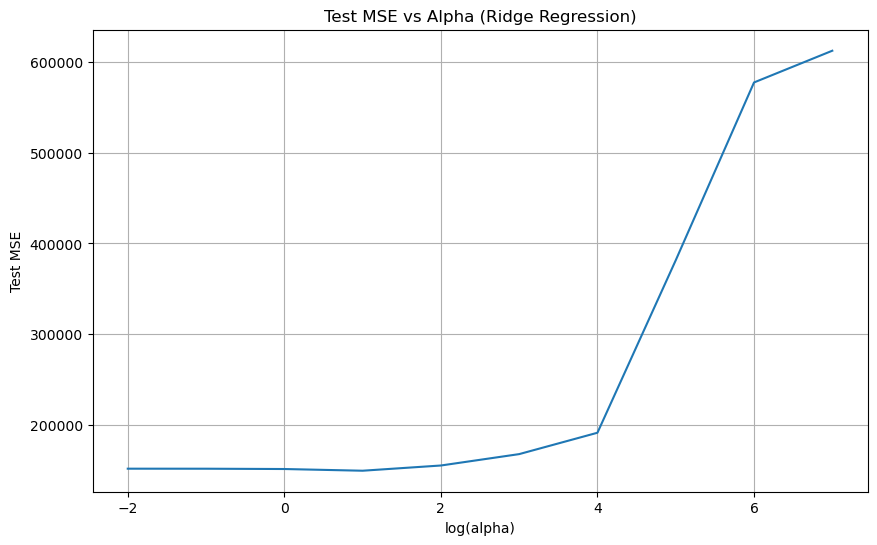

In [16]:
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

alpha_values = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
test_mse_values = []

for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train2, y_train)
    y_test_pred_ridge = ridge_model.predict(X_test2)
    mse_test_ridge = mse(y_test, y_test_pred_ridge)
    test_mse_values.append(mse_test_ridge)

plt.figure(figsize=(10, 6))
plt.plot(np.log10(alpha_values), test_mse_values)
plt.xlabel('log(alpha)')
plt.ylabel('Test MSE')
plt.title('Test MSE vs Alpha (Ridge Regression)')
plt.grid(True)
plt.show()


## Question 3 (6 marks)

List three ways one can try to prevent, detect or mitigate algorithmic bias.
For each of these three, describe and discuss briefly in maximum three sentences. As a starting point, see:

- https://www.technologyreview.com/2019/02/04/137602

- https://en.wikipedia.org/wiki/Algorithmic_bias

- https://youtu.be/fMym_BKWQzk (especially from 47:00)

- Luk Arbuckle's CANSSI Lecture shown in Week 8.

Your answer to this question should be maximum one page in length including references.

 1. **Algorithmic Hygiene Framework**:
     - **Identification**: Regularly audit all algorithms used or developed in an organization to identify for biases, and screen each algorithm for potential bias
    - **Mitigation**: Use best practices (i.e. establishing protocols for bias mitigation or a dedicated team) to address specific causes of bias,
    - **Prevention**: Implement fair and ethical deployment of machine learning technologies and put systems in place to report and document bias in algorithms transparently
    2. **External Firms & Model Auditors**:
     - **Expose organizational bias**: An impartial third party or auditors can point out failed processes and suggest improvements to current and future projects to reduce algorithmic bias.
     - **Ensure high standard**: A third party, or government entity in safety protocol can ensure a high standard compliant with regulatory, ethical, government requirements and deploy best practices in systems.
     - **Independent entity**: Allows for "Veil of Ignorance" by measuring impact of algorithms and correcting bias to achieve fairness, as well as maximize value of model by identifying aspects that lead to undesirable consequences.
    3. **Fairness-Aware Machine Learning Techniques**:
       - **Preprocessing**: Address bias during data preprocessing by balancing underrepresented groups, using re-weighting, removing discriminatory features, and ensuring equal representation.
       - **In-Processing**: Modify the learning process itself by using techniques like adversarial debiasing, and fairness constraints.
       - **Post-Processing**: Adjust model outputs to achieve fairness through a reject-option based classification to optimize and avoid becoming discriminatory against any "privileged group".
   
     These strategies, when combined, contribute to a more equitable and unbiased deployment of algorithms. Ensuring transparency, accountability, and continuous monitoring is crucial in order to mitigate algorithmic bias.
     References:
    - https://www.brookings.edu/articles/algorithmic-bias-detection-and-mitigation-best-practices-and-policies-to-reduce-consumer-harms/
    - https://en.wikipedia.org/wiki/Fairness_(machine_learning)
    - https://www.aha.org/aha-center-health-innovation-market-scan/2021-10-05-4-steps-mitigate-algorithmic-bias
    - https://hbr.org/2018/10/auditing-algorithms-for-bias